In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import GridSearchCV

In [47]:
train = pd.read_csv("../Jupyter/titanic/train.csv")
test = pd.read_csv("../Jupyter/titanic/test.csv")

union = [train, test]
passenger_id = []

<AxesSubplot:>

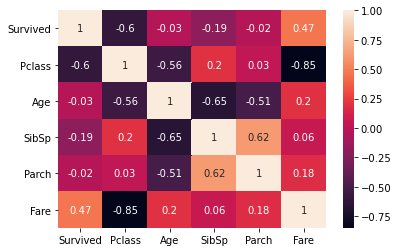

In [17]:
corr_matrix = train.drop("PassengerId", axis=1).corr().corr().round(2)
sns.heatmap(corr_matrix, annot=True)

In [10]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [48]:
for i, df in enumerate(union):

    # Age inference based on first name
    name = df['Name'].str.split('.', n=1, expand = True)
    name = name[1].str.split(expand = True)[0]
    name.replace(['(\()','(\))'],'',regex=True, inplace = True)
    df['Name'] = name
    del name
    mean_age = df[['Name','Age']].groupby(['Name']).mean()
    df = df.merge(mean_age, on='Name')
    df['Age'] = df['Age_x'].fillna(df['Age_y'])
    df = df.drop(['Age_x', 'Age_y', 'Name'], axis=1)
    
    # Age fill na as adults
    df['Age'] = df['Age'].fillna(df['Age'].mean())

    # Age bucketing
    age_buckets= [0,2,10,18,60,200]
    age_labels = [0,1,2,3,4]
    df['AgeGroup'] = pd.cut(df['Age'], bins=age_buckets, labels=age_labels, right=False)

    # Parch bucketing
    parch_buckets= [0,1,200]
    parch_labels = [0,1]
    df['Parch'] = pd.cut(df['Parch'], bins=parch_buckets, labels=parch_labels, right=False)

    # SibSp bucketing
    sibsp_buckets= [0,1,2,200]
    sibsp_labels = [0,1,2]
    df['SibSp'] = pd.cut(df['SibSp'], bins=sibsp_buckets, labels=sibsp_labels, right=False).astype(np.int8)
    
    # Fare
    #df['Fare']= df['Fare'].clip(lower= df['Fare'].quantile(0.00), upper= df['Fare'].quantile(0.01), axis=0)
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    
    # Ability to bargain
    df['Pclass'] = df['Pclass'].astype(np.int8)    
    df['Ability'] = df['Fare'] / df['Pclass']
    
    # Family size
    df['Family'] = df['SibSp'].astype(np.int8) + df['Parch'].astype(np.int8) + 1
    
    # Fare and ability bucketing quartiles
    fare_buckets= [0,23,10000]
    fare_labels = [0,1]
    df['Fare'] = pd.cut(df['Fare'], bins=fare_buckets, labels=fare_labels, right=False)
    
    ab_buckets= [0,4,9,15,20,59,70,10000]
    ab_labels = [0,1,2,3,4,5,6]
    df['Ability'] = pd.cut(df['Ability'], bins=ab_buckets, labels=ab_labels, right=False)
    
    # Cleaning
    df = df.sort_values(by=['PassengerId'])
    passenger_id.append(df["PassengerId"])
    df['Sex'] = pd.get_dummies(df['Sex'])
    df['Fare'] = pd.get_dummies(df['Fare'])
    df['SibSp'] = pd.get_dummies(df['SibSp'])
    df['Parch'] = pd.get_dummies(df['Parch'])
    df = df.drop(['Embarked', 'PassengerId', 'Ticket', 'Age', 'Cabin'], axis=1)
    union[i] = df

<AxesSubplot:>

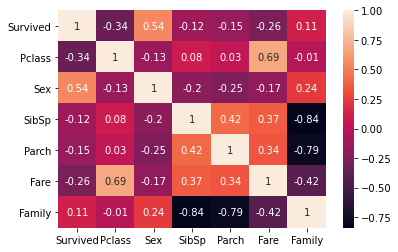

In [49]:
corr_matrix = union[0].corr().round(2)
sns.heatmap(corr_matrix,annot = True)

In [50]:
x_train = union[0].drop("Survived", axis=1)
y_train = union[0]["Survived"]
x_test  = union[1]
x_train.shape, y_train.shape, x_test.shape

((891, 8), (891,), (418, 8))

In [51]:
# Extremely randomized trees
ex = ExtraTreesClassifier(random_state = 6, bootstrap=True, oob_score=True)
ex.fit(x_train, y_train)
y_pred = ex.predict(x_test)
ex.score(x_train, y_train)
score = round(ex.score(x_train, y_train) * 100, 2)
print('Extremely Randomized Trees', score)

Extremely Randomized Trees 84.96


In [52]:
for i,j in enumerate(x_train.head(1)):
    print('%s: %s' %(j, int(ex.feature_importances_[i]*100)) + '%')

Pclass: 14%
Sex: 44%
SibSp: 2%
Parch: 3%
Fare: 6%
AgeGroup: 11%
Ability: 11%
Family: 5%


In [54]:
#submission
submission = pd.DataFrame({
        "PassengerId": passenger_id[1],
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)